In [2]:
import quandl
import pandas as pd
import numpy as np
from googlefinance import getQuotes
import json
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats.mstats import normaltest
import time
from cvxopt import matrix
import seaborn as sns
import statsmodels.tsa.stattools as ts

In [3]:
class stock(object):
    def __init__(self,ticker):
        self.ticker = ticker
tickers = ["MMM", "AXP", "AAPL", "BA", "CAT", "CVX", "CSCO","KO",
                "DIS","DD","XOM","GE","GS","HD","IBM","INTC","JPM","MCD",
                "MRK","MSFT","NKE","PFE","PG","TRV","UTX","UNH","VZ","WMT"]         
stocks = []
for i in tickers:
    vars()[i] = stock(i)
    stocks.append(vars()[i])

In [41]:
for i in stocks:
    table = quandl.get('WIKI/%s'%i.ticker,start_date = '2012-03-21',end_date = '2015-01-01')
    i.rate = np.log(table['Adj. Close']).diff().dropna()
    i.mean = np.mean(i.rate)*252
    i.std = np.std(i.rate)*np.sqrt(252)

In [42]:
spy = quandl.get('LSE/SPY5')
spy = np.log(spy['Last Close']).diff().dropna()

In [43]:
class rolling(object):
    def __init__(self,ticker,series,spy_series):
        self.ticker = ticker
        self.prices = series
        self.spy = spy_series
        self.df = pd.concat([self.prices,self.spy],axis = 1).dropna()
        self.df.columns = ['SPY','%s'%self.ticker]
        self.prices = self.df['%s'%self.ticker]
        self.spy = self.df['SPY']
        
    def roll(self, length):
        df_leng = self.df.shape[0]
        beta, beta_p, inter, inter_p,resid = [],[],[],[],[]
        loop = df_leng - length
        for i in range(loop):
            x = sm.add_constant(self.spy[i:i+length])
            model = sm.OLS(self.prices[i:i+length],x).fit()
            beta.append(model.params[1])
            beta_p.append(model.pvalues[1])
            inter.append(model.params[0])
            inter_p.append(model.pvalues[0])
        beta_df = pd.DataFrame({'beta':beta,'beta_p':beta_p,'inter':inter,'inter_p':inter_p},index = self.df.index[length:])
        self.beta_df = beta_df
        self.mean_beta = np.mean(beta)
        self.std_beta = np.std(beta)

In [44]:
for i in stocks:
    i.r = rolling(i.ticker, i.rate,spy)
    i.r.roll(21*6)

In [45]:
tickers = [x.ticker for x in stocks]
mean_betas = [x.r.mean_beta for x in stocks]
sd_betas = [x.r.std_beta for x in stocks]
beta_list = [x.r.beta_df['beta'] for x in stocks if len(x.r.beta_df['beta']) != 0]
sd_beta_p = [np.std(x.r.beta_df['beta_p']) for x in stocks]
df = pd.DataFrame({'mean_beta':mean_betas,'sd_beta':sd_betas,'sd_beta_p':sd_beta_p},index = tickers).dropna()
print(df)

      mean_beta   sd_beta  sd_beta_p
MMM    0.391424  0.106368   0.000174
AXP    0.260624  0.055665   0.000784
AAPL   0.095790  0.041038   0.095875
BA     0.190906  0.070859   0.023826
CAT    0.191012  0.063119   0.019710
CVX    0.280610  0.089215   0.011553
CSCO   0.132116  0.067679   0.115558
KO     0.181293  0.166132   0.309038
DIS    0.254268  0.063585   0.000340
DD     0.247352  0.057332   0.002610
XOM    0.292914  0.150067   0.026876
GE     0.256557  0.075137   0.010253
GS     0.237748  0.029856   0.000318
HD     0.219472  0.061830   0.012097
IBM    0.212634  0.112679   0.055888
INTC   0.152051  0.073508   0.057509
JPM    0.222741  0.057927   0.008795
MCD    0.243713  0.113179   0.189099
MRK    0.170320  0.062014   0.049013
MSFT   0.211149  0.104175   0.008382
NKE    0.115547  0.066427   0.252076
PFE    0.247528  0.092036   0.012432
PG     0.197096  0.159905   0.280305
UTX    0.318099  0.081374   0.000436
UNH    0.135254  0.032307   0.036826
VZ     0.170965  0.087304   0.082649
W

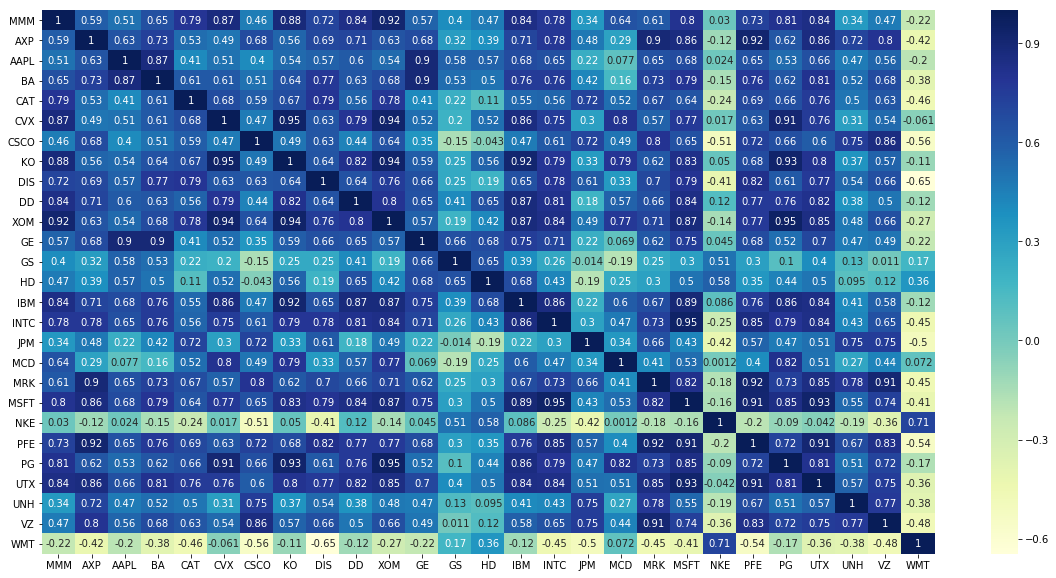

In [47]:
cov_matrix = np.corrcoef(beta_list)
cov_df = pd.DataFrame(cov_matrix)
plt.figure(figsize = (20,10))
sns.heatmap(cov_df, xticklabels = df.index, yticklabels = df.index,annot=True,cmap="YlGnBu")

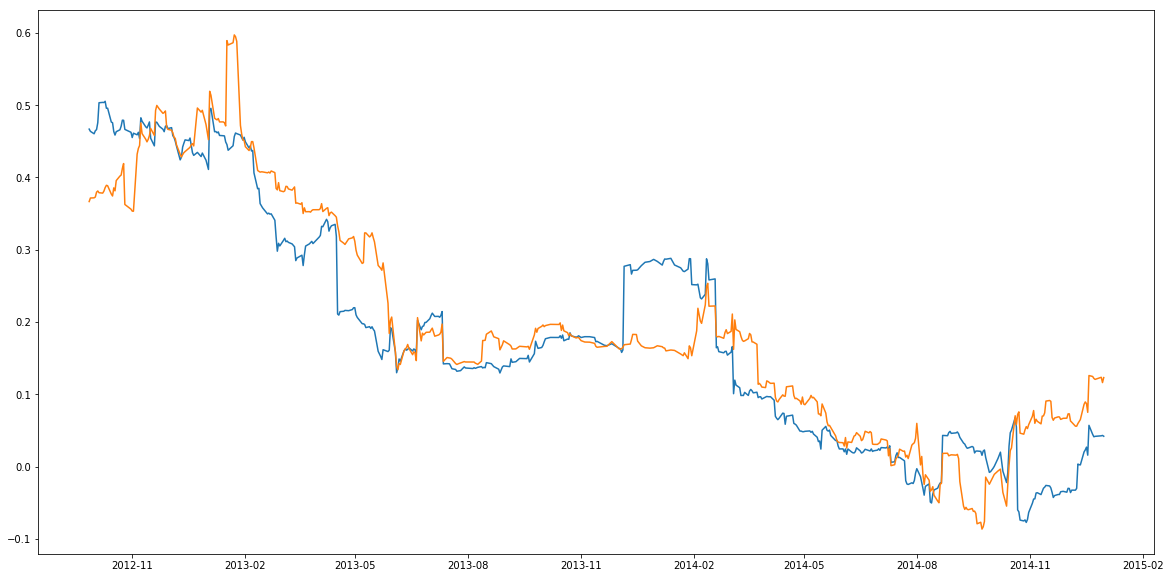

In [56]:
plt.figure(figsize = (20,10))
p_df = pd.DataFrame({'XOM':PG.r.beta_df['beta'],'PG':XOM.r.beta_df['beta']})
plt.plot(KO.r.beta_df['beta'])
plt.plot(PG.r.beta_df['beta'])

In [55]:
x = sm.add_constant(PG.r.beta_df['beta'])
coint = sm.OLS(KO.r.beta_df['beta'],x).fit()
print(coint.summary())
adf = ts.adfuller(coint.resid,autolag = 'BIC')[0]
print(adf)

                            OLS Regression Results                            
Dep. Variable:                   beta   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     3363.
Date:                Tue, 01 Aug 2017   Prob (F-statistic):          6.92e-225
Time:                        12:43:08   Log-Likelihood:                 704.82
No. Observations:                 505   AIC:                            -1406.
Df Residuals:                     503   BIC:                            -1397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0097      0.004     -2.285      0.0

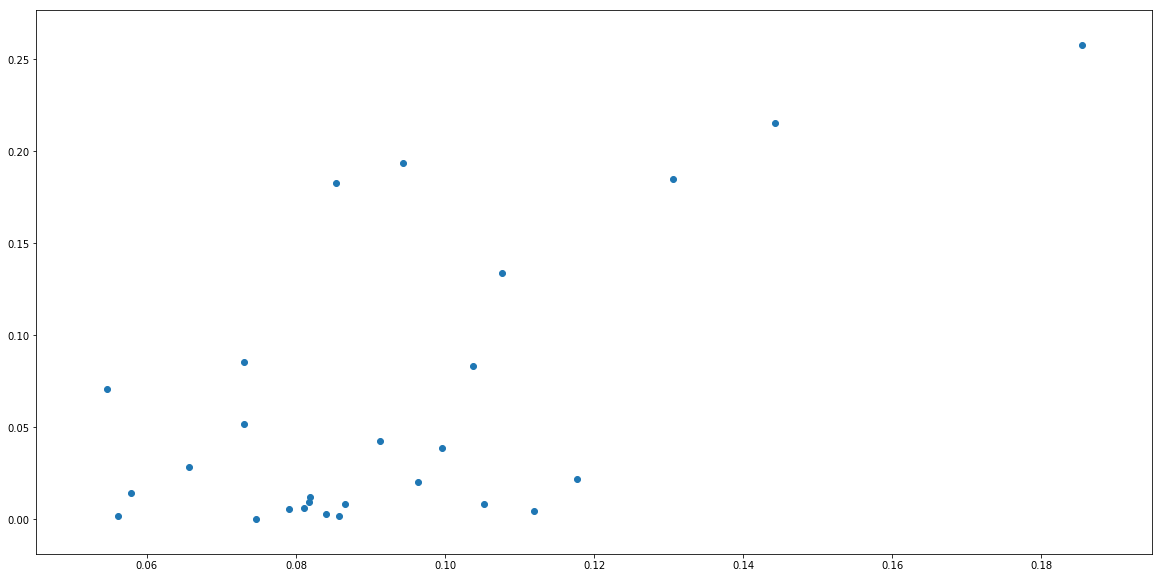

In [12]:
plt.figure(figsize = (20,10))
plt.scatter(df['sd_beta'],df['sd_beta_p'])

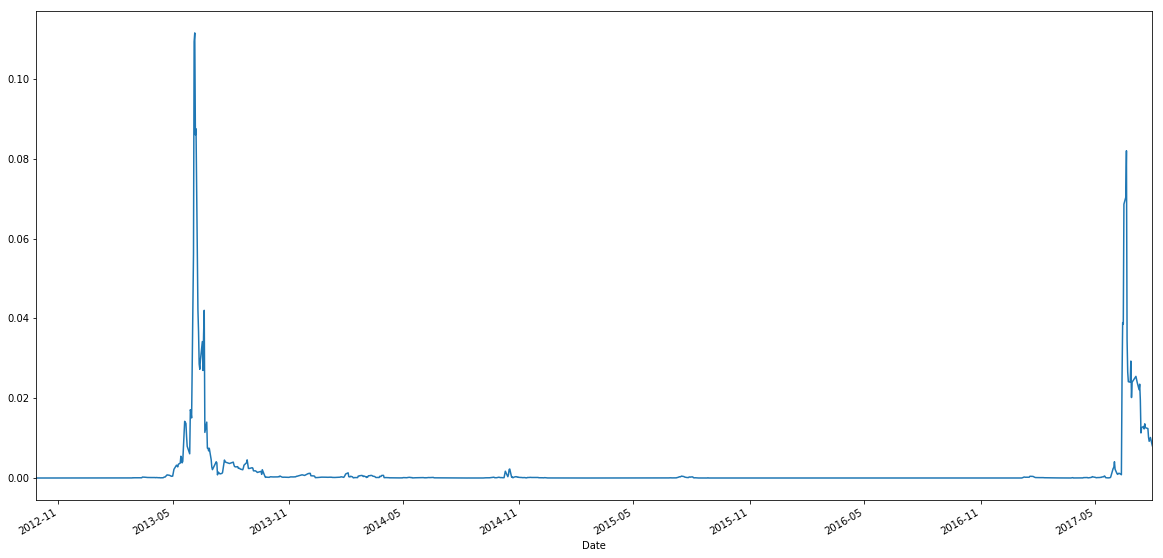

In [13]:
plt.figure(figsize = (20,10))
GE.r.beta_df['beta_p'].plot()
plt.show()